# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from datetime import datetime

Открываем файлы и сохраняем данные в датафреймы

In [2]:
df = pd.read_csv('./datasets/autos.csv')

## Предобработка и исследовательский анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

***Описание данных***

Признаки:

* `DateCrawled` — дата скачивания анкеты из базы;
* `VehicleType` — тип автомобильного кузова;
* `RegistrationYear` — год регистрации автомобиля;
* `Gearbox` — тип коробки передач;
* `Power` — мощность (л. с.);
* `Model` — модель автомобиля;
* `Kilometer` — пробег (км);
* `RegistrationMonth` — месяц регистрации автомобиля;
* `FuelType` — тип топлива;
* `Brand` — марка автомобиля;
* `NotRepaired` — была машина в ремонте или нет;
* `DateCreated` — дата создания анкеты;
* `NumberOfPictures` — количество фотографий автомобиля;
* `PostalCode` — почтовый индекс владельца анкеты (пользователя);
* `LastSeen` — дата последней активности пользователя.

Целевой признак:

* `Price` — цена (евро).

Удалим лишние признаки, которые не влияют на стоимость автомобиля: `DateCrawled` — дата скачивания анкеты из базы, `DateCreated` — дата создания анкеты, `PostalCode` — почтовый индекс владельца анкеты (пользователя), `LastSeen` — дата последней активности пользователя.

In [4]:
df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen'], inplace=True, axis=1)

In [5]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0


In [6]:
print('Количество пропусков в каждом столбце:') 
df.isna().agg(lambda x: '{:.2%} '.format(x.mean()))

Количество пропусков в каждом столбце:


Price                 0.00% 
VehicleType          10.58% 
RegistrationYear      0.00% 
Gearbox               5.60% 
Power                 0.00% 
Model                 5.56% 
Kilometer             0.00% 
RegistrationMonth     0.00% 
FuelType              9.28% 
Brand                 0.00% 
NotRepaired          20.08% 
NumberOfPictures      0.00% 
dtype: object

* В пяти столбцах большой процент пропусков данных от 5 до 20 %, удалив их, потерям значительную часть данных, поэтому поместим их в специальную группу "unknown"

In [7]:
print('Количество пропусков в каждом столбце:') 
df.isna().agg(lambda x: '{:.2%} '.format(x.mean()))

Количество пропусков в каждом столбце:


Price                 0.00% 
VehicleType          10.58% 
RegistrationYear      0.00% 
Gearbox               5.60% 
Power                 0.00% 
Model                 5.56% 
Kilometer             0.00% 
RegistrationMonth     0.00% 
FuelType              9.28% 
Brand                 0.00% 
NotRepaired          20.08% 
NumberOfPictures      0.00% 
dtype: object

* Всё пропуски удалены

In [8]:
df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']] = \
    df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].fillna('unknown')

Проверим ключевой признак и признаки, на корректность данных

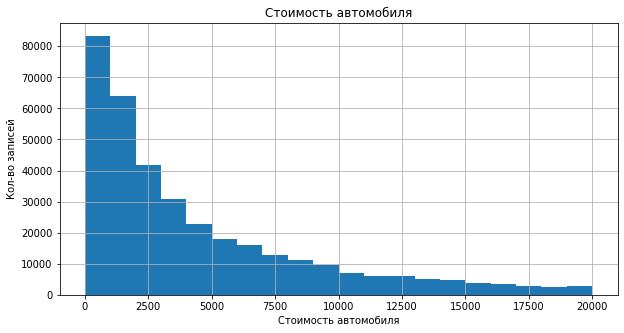

In [9]:
df['Price'].hist(figsize=(10, 5), grid=True, bins=20)
plt.xlabel("Стоимость автомобиля")
plt.ylabel("Кол-во записей")
plt.title("Стоимость автомобиля")
plt.show()    

* Удалим строки с нереалистичной ценой, меньше 100 евро

In [10]:
df = df.query('Price > 100')

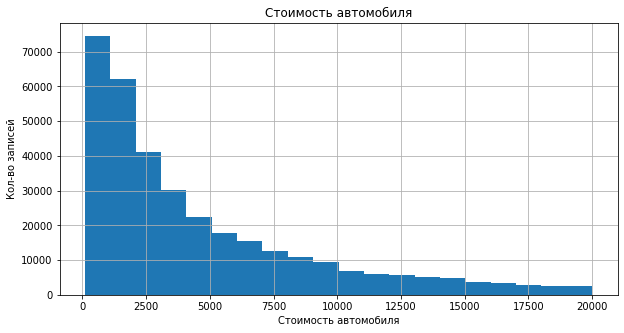

In [11]:
df['Price'].hist(figsize=(10, 5), grid=True, bins=20)
plt.xlabel("Стоимость автомобиля")
plt.ylabel("Кол-во записей")
plt.title("Стоимость автомобиля")
plt.show()    

In [12]:
df['Price'].describe()  

count    340024.000000
mean       4602.471902
std        4514.902742
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

* Данные корректны

In [13]:
df['VehicleType'].value_counts()

sedan          88965
small          77029
wagon          63384
unknown        32251
bus            28256
convertible    19807
coupe          15534
suv            11758
other           3040
Name: VehicleType, dtype: int64

* Данные корректны

Отобразим данные года регистрации автомобиля, в реалистичном диапазоне с 1900 г. по 2022 г.

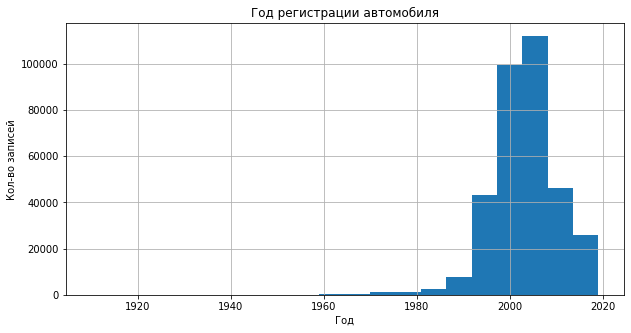

In [14]:
df.query('1900 < RegistrationYear < 2022')['RegistrationYear'].hist(figsize=(10, 5), grid=True, bins=20)
plt.xlabel("Год")
plt.ylabel("Кол-во записей")
plt.title("Год регистрации автомобиля")
plt.show()    

* Удалим выбросы, год регестрации автомобиля до 1960 г. и после 2022 г.

In [15]:
df = df.query('1960 < RegistrationYear < 2022')

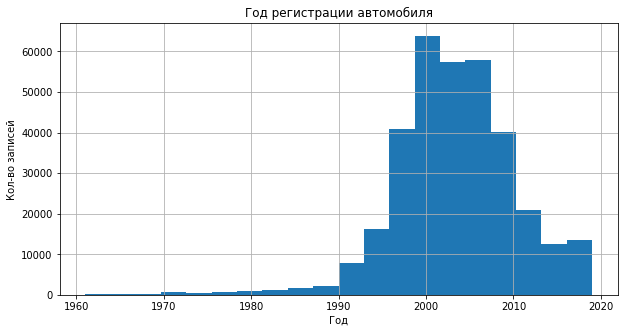

In [16]:
df['RegistrationYear'].hist(figsize=(10, 5), grid=True, bins=20)
plt.xlabel("Год")
plt.ylabel("Кол-во записей")
plt.title("Год регистрации автомобиля")
plt.show()    

* Данные корректны

Отобразим данные мощность (л.с.) автомобиля, в реалистичном диапазоне менее 500 л.с.

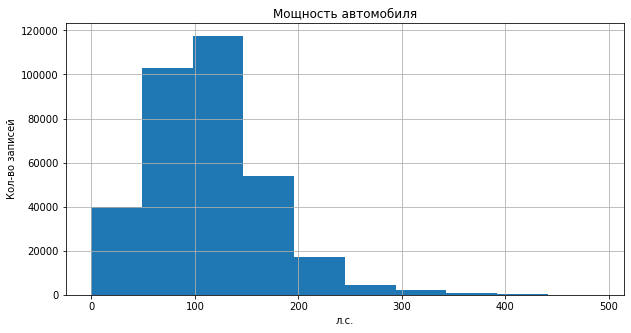

In [17]:
df.query('Power < 500')['Power'].hist(figsize=(10, 5), grid=True)
plt.xlabel("л.с.")
plt.ylabel("Кол-во записей")
plt.title("Мощность автомобиля")
plt.show()   

* Обнаруженно много выбросов, особенно нулевых значений, видимо это пропущенные данные. Приравняем все выбросы к 0 (менее 40 л.с. и более 350 л.с.)

In [18]:
df['Power'] = df['Power'].agg(lambda x: 0 if x<40 or x>350 else x)

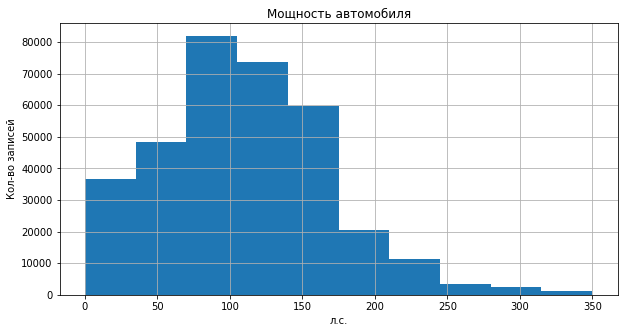

In [19]:
df['Power'].hist(figsize=(10, 5), grid=True)
plt.xlabel("л.с.")
plt.ylabel("Кол-во записей")
plt.title("Мощность автомобиля")
plt.show()   

* Данные корректны

In [20]:
df['Gearbox'].value_counts()

manual     259068
auto        64593
unknown     15877
Name: Gearbox, dtype: int64

* Данные корректны

In [21]:
df['Model'].value_counts()

golf                  27976
other                 23254
3er                   19058
unknown               16691
polo                  12413
                      ...  
serie_2                   7
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 251, dtype: int64

* Данные корректны

Для удобства разделим пробег автомобиля на тыс.

In [22]:
df['Kilometer'] /= 1000

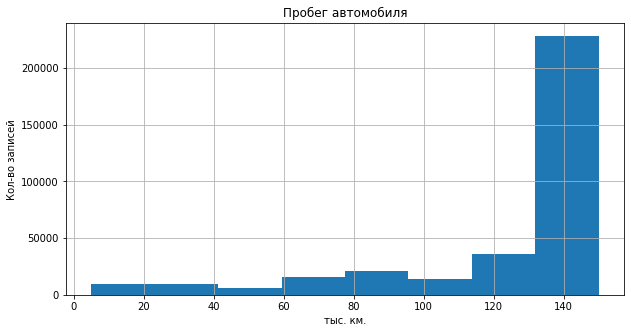

In [23]:
df['Kilometer'].hist(figsize=(10, 5), grid=True, bins=8)
plt.xlabel("тыс. км.")
plt.ylabel("Кол-во записей")
plt.title("Пробег автомобиля")
plt.show()    

* Данные корректны

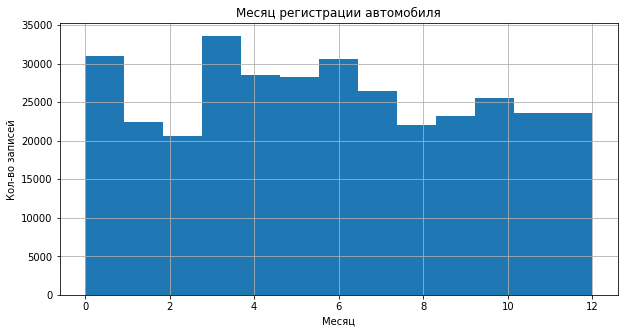

In [24]:
df['RegistrationMonth'].hist(figsize=(10, 5), grid=True, bins=13)
plt.xlabel("Месяц")
plt.ylabel("Кол-во записей")
plt.title("Месяц регистрации автомобиля")
plt.show()    

* Данные корректны

In [25]:
df['FuelType'].value_counts()

petrol      208663
gasoline     96892
unknown      27817
lpg           5154
cng            548
hybrid         226
other          152
electric        86
Name: FuelType, dtype: int64

* Данные корректны

In [26]:
df['Brand'].value_counts()

volkswagen        73632
opel              37927
bmw               35512
mercedes_benz     31159
audi              28388
ford              24014
renault           17126
peugeot           10670
fiat               9189
seat               6650
skoda              5415
mazda              5414
smart              5148
citroen            4948
nissan             4761
toyota             4525
hyundai            3512
mini               3156
volvo              3091
mitsubishi         2894
honda              2695
sonstige_autos     2543
kia                2391
suzuki             2245
alfa_romeo         2199
chevrolet          1684
chrysler           1343
dacia               888
daihatsu            753
subaru              716
porsche             699
jeep                640
land_rover          532
daewoo              521
saab                512
jaguar              486
trabant             453
rover               451
lancia              444
lada                212
Name: Brand, dtype: int64

* Данные корректны

In [27]:
df['NotRepaired'].value_counts()

no         242885
unknown     63612
yes         33041
Name: NotRepaired, dtype: int64

* Данные корректны

In [28]:
df['NumberOfPictures'].value_counts()

0    339538
Name: NumberOfPictures, dtype: int64

* все данные равны нулю, данный столбец не несёт смысловой нагрузки, удалим его. 

In [29]:
df.drop(['NumberOfPictures'], inplace=True, axis=1)

Уменьшим размерность хранения типа для ускорения работы с дата фреймом.

In [30]:
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'], downcast='integer')
df['RegistrationMonth'] = pd.to_numeric(df['RegistrationMonth'], downcast='integer')
df['Power'] = pd.to_numeric(df['Power'], downcast='integer')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], downcast='integer')
df['Price'] = pd.to_numeric(df['Price'], downcast='integer')

In [31]:
df = df.drop_duplicates()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313560 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              313560 non-null  int16 
 1   VehicleType        313560 non-null  object
 2   RegistrationYear   313560 non-null  int16 
 3   Gearbox            313560 non-null  object
 4   Power              313560 non-null  int16 
 5   Model              313560 non-null  object
 6   Kilometer          313560 non-null  int16 
 7   RegistrationMonth  313560 non-null  int8  
 8   FuelType           313560 non-null  object
 9   Brand              313560 non-null  object
 10  NotRepaired        313560 non-null  object
dtypes: int16(4), int8(1), object(6)
memory usage: 19.4+ MB


Посмотрим матрицу корреляции

In [33]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.387387,0.467009,-0.356784,0.091417
RegistrationYear,0.387387,1.000000,0.099228,-0.209105,0.031673
Power,0.467009,0.099228,1.000000,0.082276,0.111773
Kilometer,-0.356784,-0.209105,0.082276,1.000000,-0.005160
RegistrationMonth,0.091417,0.031673,0.111773,-0.005160,1.000000


Обнаружены следующие линейные зависимости:
    
`Price` (цена автомобиля):

* Прямая линейная средняя зависимость (0,395) от года регистрации автомобиля;
* Прямая линейная средняя зависимость (0,471) от мощности автомобиля;
* Обратная линейная средняя зависимость (-0,363) от пробега автомобиля.

`RegistrationYear` (Год регистрации автомобиля):

* Обратная линейная слабая зависимость (0,218) от пробега автомобиля.

* Данные подготовлены, можно переходить к следующему этапу

## Обучение моделей

### Подготовка признаков

Перемешаем данные для лучшего обучения модели

In [34]:
df = df.sample(frac=1, random_state=12345)

Создадим списки с категориальными и числовыми признаками

In [35]:
str_columns = ['VehicleType','Gearbox','Model','FuelType','Brand', 'NotRepaired']
number_columns = ['RegistrationYear','Power','Kilometer','RegistrationMonth']

Заменим тип данных в категириальных признаках с `object` на `category` для корректной работы модели градиентного бустинга LightGBM

In [36]:
for c in str_columns:
    df[c] = df[c].astype('category')

Создадим две выборки: признаки и ключевой признак

In [37]:
features = df.drop('Price', axis=1)
target = df['Price']

Проведем OHE кодирование

In [38]:
ohe_features = pd.get_dummies(features, drop_first=True)

Разобьём выборки на тренировочные и тестовые

In [39]:
ohe_features_train, ohe_features_test, features_train, features_test, \
    target_train, target_test = train_test_split(
    ohe_features, features, target, test_size=0.25, random_state=12345)

In [40]:
print(f'Итоговые размеры выборок , обучающая:валидационная - '
      f'{target_train.count()}:{target_test.count()}' 
      f'({round(target_train.count()/target_test.count())}:1)')

Итоговые размеры выборок , обучающая:валидационная - 235170:78390(3:1)


* Выборки готовы, можно приступать к обучению моделей

### Линейная регрессия 

Обучим модель

In [41]:
start_time = datetime.now() 
linear_model = LinearRegression().fit(ohe_features_train, target_train)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:02.016455


In [42]:
%%time
linear_model = LinearRegression().fit(ohe_features_train, target_train)

CPU times: total: 14.8 s
Wall time: 2.16 s


Получим предсказания модели

In [43]:
linear_predict = linear_model.predict(ohe_features_test)

Посчитаем и выведем на экран, метрику RMSE

In [44]:
linear_rmse = mean_squared_error(target_test, linear_predict) ** 0.5
print(f'RMSE: {linear_rmse:.2f}')

RMSE: 2732.85


### Дерево решений

In [45]:
tree_model = DecisionTreeRegressor() 

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [46]:
params_tree = {
    'criterion':['squared_error'],
    'max_depth':range(23, 26, 1),
    'min_samples_leaf': range (12,15,1),
    'random_state':[12345]
}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели и обучим её

In [47]:
%%time
tree_grid = GridSearchCV(tree_model, params_tree, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
tree_grid.fit(ohe_features_train, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: total: 6.59 s
Wall time: 31.5 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': range(23, 26),
                         'min_samples_leaf': range(12, 15),
                         'random_state': [12345]},
             scoring='neg_mean_squared_error', verbose=3)

Отобразим лучшие гиперпараметры

In [48]:
tree_best_params = tree_grid.best_params_
tree_best_params

{'criterion': 'squared_error',
 'max_depth': 24,
 'min_samples_leaf': 13,
 'random_state': 12345}

Получим предсказания модели

In [49]:
tree_predict = tree_grid.predict(ohe_features_test)

Посчитаем и выведем на экран, метрику RMSE

In [50]:
rmse_tree = mean_squared_error(target_test, tree_predict) ** 0.5
print(f'RMSE: {rmse_tree:.2f}')

RMSE: 1870.36


### Случайный лес

In [51]:
forest_model = RandomForestRegressor(n_jobs=-1)

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [52]:
forest_params = {
    'criterion':['squared_error'],
    'max_depth':range(22, 25, 1),
    'random_state':[12345]
}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели и обучим её

In [53]:
%%time
forest_grid = GridSearchCV(forest_model, forest_params, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
forest_grid.fit(ohe_features_train, target_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
CPU times: total: 20min 35s
Wall time: 4min 43s


GridSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': range(22, 25), 'random_state': [12345]},
             scoring='neg_mean_squared_error', verbose=3)

Отобразим лучшие гиперпараметры

In [54]:
forest_grid.best_params_

{'criterion': 'squared_error', 'max_depth': 23, 'random_state': 12345}

Получим предсказания модели

In [55]:
forest_predict = forest_grid.predict(ohe_features_test)

Посчитаем и выведем на экран, метрику RMSE

In [56]:
rmse_forest = mean_squared_error(target_test, forest_predict) ** 0.5
print(f'RMSE: {rmse_forest:.2f}')

RMSE: 1701.12


### Ridge

In [57]:
ridge_model = Ridge()

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [58]:
ridge_params = {'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели и обучим её

In [59]:
%%time
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=3, scoring='neg_mean_squared_error', verbose=3)
ridge_grid.fit(ohe_features_train, target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ................solver=auto;, score=-7385050.365 total time=   0.9s
[CV 2/3] END ................solver=auto;, score=-7228146.697 total time=   0.9s
[CV 3/3] END ................solver=auto;, score=-7359177.802 total time=   0.9s
[CV 1/3] END .................solver=svd;, score=-7385050.365 total time=   2.1s
[CV 2/3] END .................solver=svd;, score=-7228146.697 total time=   2.0s
[CV 3/3] END .................solver=svd;, score=-7359177.802 total time=   2.0s
[CV 1/3] END ............solver=cholesky;, score=-7385050.365 total time=   0.9s
[CV 2/3] END ............solver=cholesky;, score=-7228146.697 total time=   0.9s
[CV 3/3] END ............solver=cholesky;, score=-7359177.802 total time=   0.9s
[CV 1/3] END ................solver=lsqr;, score=-8757681.969 total time=   0.8s
[CV 2/3] END ................solver=lsqr;, score=-8613235.321 total time=   0.7s
[CV 3/3] END ................solver=lsqr;, score=

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg']},
             scoring='neg_mean_squared_error', verbose=3)

Отобразим лучшие гиперпараметры

In [60]:
ridge_grid.best_params_

{'solver': 'svd'}

Получим предсказания модели

In [61]:
ridge_predict = ridge_grid.predict(ohe_features_test)

Посчитаем и выведем на экран, метрику RMSE

In [62]:
rmse_ridge = mean_squared_error(target_test, ridge_predict) ** 0.5
print(f'RMSE: {rmse_ridge:.2f}')

RMSE: 2732.97


### Градиентный бустинг LightGBM

In [63]:
lgbm_model = LGBMRegressor(random_state=12345, verbose=4)

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [64]:
lgbm_params = {
    'learning_rate': [0.05, 0.1, 0.15], 
    'num_leaves': range(500, 610, 25),
    'force_col_wise': ['true']
}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели и обучим её

In [65]:
%%time
lgbm_grid = GridSearchCV(lgbm_model, lgbm_params, cv=3, scoring='neg_mean_squared_error', verbose=3)
lgbm_grid.fit(features_train, target_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.736408
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4578.288391
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[Light

[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth 

[CV 2/3] END force_col_wise=true, learning_rate=0.05, num_leaves=525;, score=-2640315.894 total time=   1.8s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.737074
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4577.614511
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth 

[CV 2/3] END force_col_wise=true, learning_rate=0.05, num_leaves=575;, score=-2648205.626 total time=   2.0s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.737074
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4577.614511
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth 

[CV 2/3] END force_col_wise=true, learning_rate=0.1, num_leaves=500;, score=-2622220.114 total time=   1.6s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.737074
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4577.614511
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 17
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 30
[CV 2/3] END force_col_wise=true, learning_rate=0.1, num_leaves=550;, score=-2623391.869 total time=   1.8s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.737074
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4577.614511
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained

[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 27
[CV 1/3] END force_col_wise=true, learning_rate=0.1, num_leaves=600;, score=-2586674.224 total time=   1.8s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.736609
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Inf

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 500 and depth 

[CV 1/3] END force_col_wise=true, learning_rate=0.15, num_leaves=525;, score=-2624014.775 total time=   1.5s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.736609
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4585.264925
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 15
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 525 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 38
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 38
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

[CV 3/3] END force_col_wise=true, learning_rate=0.15, num_leaves=550;, score=-2571838.567 total time=   1.5s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.736408
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4578.288391
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 17
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 40
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 575 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 38
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth 

[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 27
[CV 2/3] END force_col_wise=true, learning_rate=0.15, num_leaves=600;, score=-2667658.685 total time=   1.7s
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.737074
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 156780, number of used features: 10
[LightGBM] [Info] Start training from score 4577.614511
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 550 and depth 

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345, verbose=4),
             param_grid={'force_col_wise': ['true'],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'num_leaves': range(500, 610, 25)},
             scoring='neg_mean_squared_error', verbose=3)

Отобразим лучшие гиперпараметры

In [66]:
lgbm_grid.best_params_

{'force_col_wise': 'true', 'learning_rate': 0.1, 'num_leaves': 550}

Получим предсказания модели

In [67]:
lgbm_predict = lgbm_grid.predict(features_test)

Посчитаем и выведем на экран, метрику RMSE

In [68]:
lgbm_rmse = mean_squared_error(target_test, lgbm_predict) ** 0.5
print(f'RMSE: {lgbm_rmse:.2f}')

RMSE: 1594.88


### Градиентный бустинг CatBoost

In [69]:
catboost_model = CatBoostRegressor(cat_features=str_columns,
                                   random_state=12345,
                                   verbose=3)

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [70]:
catboost_params = {'learning_rate':[0.2, 0.25, 0.3]}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели и обучим её

In [71]:
%%time
catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
catboost_grid.fit(features_train, target_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	learn: 3821.3195910	total: 260ms	remaining: 4m 19s
3:	learn: 2718.4060355	total: 626ms	remaining: 2m 35s
6:	learn: 2289.3752941	total: 950ms	remaining: 2m 14s
9:	learn: 2096.1899899	total: 1.25s	remaining: 2m 4s
12:	learn: 2011.5668644	total: 1.55s	remaining: 1m 57s
15:	learn: 1957.3495278	total: 1.84s	remaining: 1m 53s
18:	learn: 1923.4197824	total: 2.17s	remaining: 1m 52s
21:	learn: 1894.2886774	total: 2.48s	remaining: 1m 50s
24:	learn: 1873.9318223	total: 2.73s	remaining: 1m 46s
27:	learn: 1856.8813978	total: 3.07s	remaining: 1m 46s
30:	learn: 1843.0245839	total: 3.36s	remaining: 1m 45s
33:	learn: 1829.8506333	total: 3.72s	remaining: 1m 45s
36:	learn: 1817.7610329	total: 4.03s	remaining: 1m 44s
39:	learn: 1806.7458559	total: 4.38s	remaining: 1m 45s
42:	learn: 1797.6551987	total: 4.76s	remaining: 1m 46s
45:	learn: 1788.9109115	total: 5.07s	remaining: 1m 45s
48:	learn: 1782.3069773	total: 5.38s	remaining: 1m 44s
51:	learn: 

444:	learn: 1574.3696601	total: 50.1s	remaining: 1m 2s
447:	learn: 1573.9975299	total: 50.5s	remaining: 1m 2s
450:	learn: 1573.1928567	total: 50.8s	remaining: 1m 1s
453:	learn: 1572.5544073	total: 51.2s	remaining: 1m 1s
456:	learn: 1572.0224201	total: 51.6s	remaining: 1m 1s
459:	learn: 1571.6152338	total: 52s	remaining: 1m
462:	learn: 1571.0745554	total: 52.3s	remaining: 1m
465:	learn: 1570.1524529	total: 52.7s	remaining: 1m
468:	learn: 1569.5641709	total: 53s	remaining: 1m
471:	learn: 1569.0286771	total: 53.3s	remaining: 59.6s
474:	learn: 1568.5817090	total: 53.7s	remaining: 59.3s
477:	learn: 1567.9975191	total: 54s	remaining: 59s
480:	learn: 1567.5959645	total: 54.3s	remaining: 58.6s
483:	learn: 1567.3174096	total: 54.7s	remaining: 58.3s
486:	learn: 1566.8856831	total: 55s	remaining: 57.9s
489:	learn: 1566.2794101	total: 55.3s	remaining: 57.6s
492:	learn: 1565.6467478	total: 55.6s	remaining: 57.2s
495:	learn: 1564.9436949	total: 56s	remaining: 56.9s
498:	learn: 1564.6121378	total: 56

891:	learn: 1510.6812891	total: 1m 40s	remaining: 12.2s
894:	learn: 1510.3573580	total: 1m 40s	remaining: 11.8s
897:	learn: 1510.0500694	total: 1m 41s	remaining: 11.5s
900:	learn: 1509.7544674	total: 1m 41s	remaining: 11.2s
903:	learn: 1509.5453949	total: 1m 42s	remaining: 10.8s
906:	learn: 1509.3721934	total: 1m 42s	remaining: 10.5s
909:	learn: 1509.0778860	total: 1m 42s	remaining: 10.2s
912:	learn: 1508.9577887	total: 1m 43s	remaining: 9.82s
915:	learn: 1508.3274146	total: 1m 43s	remaining: 9.48s
918:	learn: 1508.0316095	total: 1m 43s	remaining: 9.15s
921:	learn: 1507.8090804	total: 1m 44s	remaining: 8.81s
924:	learn: 1507.5961758	total: 1m 44s	remaining: 8.47s
927:	learn: 1507.3282132	total: 1m 44s	remaining: 8.13s
930:	learn: 1507.0945375	total: 1m 45s	remaining: 7.79s
933:	learn: 1506.5758519	total: 1m 45s	remaining: 7.45s
936:	learn: 1506.2545442	total: 1m 45s	remaining: 7.12s
939:	learn: 1505.9633492	total: 1m 46s	remaining: 6.78s
942:	learn: 1505.5041452	total: 1m 46s	remaining

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001D9D7DE5130>,
             n_jobs=-1, param_grid={'learning_rate': [0.2, 0.25, 0.3]},
             scoring='neg_mean_squared_error', verbose=1)

Отобразим лучшие гиперпараметры

In [72]:
catboost_grid.best_params_

{'learning_rate': 0.25}

Получим предсказания модели

In [73]:
catboost_predict = catboost_grid.predict(features_test)

Посчитаем и выведем на экран, метрику RMSE

In [74]:
catboost_rmse = mean_squared_error(target_test, catboost_predict) ** 0.5
print(f'RMSE: {catboost_rmse:.2f}')

RMSE: 1638.36


## Анализ моделей

Создадим пустые списки для записи параметров моделей: качество, время обучения и скорость предсказания модели

In [75]:
rmse = []
training_time = []
prediction_time = []

### Линейная регрессия

In [76]:
linear_model = LinearRegression()

Обучим модель

In [77]:
start_time = datetime.now() 
linear_model.fit(ohe_features_train, target_train)
training_time.append(datetime.now() - start_time)

Получим предсказания модели

In [78]:
start_time = datetime.now() 
linear_predict = linear_model.predict(ohe_features_test)
prediction_time.append(datetime.now() - start_time)

Посчитаем и выведем на экран, метрику RMSE

In [79]:
linear_rmse = mean_squared_error(target_test, linear_predict) ** 0.5
print(f'RMSE: {linear_rmse:.2f}')
rmse.append(round(linear_rmse,2))

RMSE: 2732.85


### Дерево решений

In [80]:
tree_model = DecisionTreeRegressor(max_depth=24,
                                   min_samples_leaf=13,
                                   random_state=12345) 

Обучим модель

In [81]:
start_time = datetime.now() 
tree_model.fit(ohe_features_train, target_train)
training_time.append(datetime.now() - start_time)

Получим предсказания модели

In [82]:
start_time = datetime.now() 
tree_predict = tree_model.predict(ohe_features_test)
prediction_time.append(datetime.now() - start_time)

Посчитаем и выведем на экран, метрику RMSE

In [83]:
tree_rmse = mean_squared_error(target_test, tree_predict) ** 0.5
print(f'RMSE: {tree_rmse:.2f}')
rmse.append(round(tree_rmse,2))

RMSE: 1870.36


### Случайный лес

In [84]:
forest_model = RandomForestRegressor(max_depth=23, n_jobs=-1, random_state=12345)

Обучим модель

In [85]:
start_time = datetime.now() 
forest_model.fit(ohe_features_train, target_train)
training_time.append(datetime.now() - start_time)

Получим предсказания модели

In [86]:
start_time = datetime.now() 
forest_predict = forest_model.predict(ohe_features_test)
prediction_time.append(datetime.now() - start_time)

Посчитаем и выведем на экран, метрику RMSE

In [87]:
forest_rmse = mean_squared_error(target_test, forest_predict) ** 0.5
print(f'RMSE: {forest_rmse:.2f}')
rmse.append(round(forest_rmse,2))

RMSE: 1701.12


### Градиентный бустинг LightGBM

In [88]:
lgbm_model = LGBMRegressor(learning_rate=0.1,
                           num_leaves=550,
                           force_col_wise=True,
                           random_state=12345)

Обучим модель

In [89]:
start_time = datetime.now() 
lgbm_model.fit(features_train, target_train)
training_time.append(datetime.now() - start_time)

Получим предсказания модели

In [90]:
start_time = datetime.now() 
lgbm_predict = lgbm_model.predict(features_test)
prediction_time.append(datetime.now() - start_time)

Посчитаем и выведем на экран, метрику RMSE

In [91]:
lgbm_rmse = mean_squared_error(target_test, lgbm_predict) ** 0.5
print(f'RMSE: {lgbm_rmse:.2f}')
rmse.append(round(lgbm_rmse,2))

RMSE: 1594.88


### Градиентный бустинг CatBoost

In [92]:
catboost_model = CatBoostRegressor(learning_rate=0.25,
                                   cat_features=str_columns,
                                   random_state=12345)

Обучим модель

In [93]:
start_time = datetime.now() 
catboost_model.fit(features_train, target_train)
training_time.append(datetime.now() - start_time)

0:	learn: 3821.3195910	total: 138ms	remaining: 2m 18s
1:	learn: 3334.5901165	total: 251ms	remaining: 2m 5s
2:	learn: 2981.9147393	total: 368ms	remaining: 2m 2s
3:	learn: 2718.4060355	total: 498ms	remaining: 2m 3s
4:	learn: 2520.9163136	total: 602ms	remaining: 1m 59s
5:	learn: 2382.6157768	total: 701ms	remaining: 1m 56s
6:	learn: 2289.3752941	total: 811ms	remaining: 1m 54s
7:	learn: 2207.2086148	total: 927ms	remaining: 1m 54s
8:	learn: 2142.9624543	total: 1.03s	remaining: 1m 53s
9:	learn: 2096.1899899	total: 1.16s	remaining: 1m 55s
10:	learn: 2058.8548944	total: 1.26s	remaining: 1m 53s
11:	learn: 2031.8697229	total: 1.37s	remaining: 1m 53s
12:	learn: 2011.5668644	total: 1.48s	remaining: 1m 52s
13:	learn: 1987.7043182	total: 1.59s	remaining: 1m 51s
14:	learn: 1973.1966557	total: 1.7s	remaining: 1m 51s
15:	learn: 1957.3495278	total: 1.82s	remaining: 1m 51s
16:	learn: 1944.7107075	total: 1.89s	remaining: 1m 49s
17:	learn: 1934.7299714	total: 2.02s	remaining: 1m 50s
18:	learn: 1923.4197824	

150:	learn: 1664.1224153	total: 16.7s	remaining: 1m 33s
151:	learn: 1663.4409551	total: 16.8s	remaining: 1m 33s
152:	learn: 1663.0574763	total: 16.9s	remaining: 1m 33s
153:	learn: 1662.4689979	total: 17s	remaining: 1m 33s
154:	learn: 1661.8476326	total: 17.1s	remaining: 1m 33s
155:	learn: 1661.4726063	total: 17.2s	remaining: 1m 33s
156:	learn: 1660.8316578	total: 17.3s	remaining: 1m 33s
157:	learn: 1660.6919768	total: 17.5s	remaining: 1m 33s
158:	learn: 1660.1625123	total: 17.6s	remaining: 1m 32s
159:	learn: 1660.0543775	total: 17.7s	remaining: 1m 32s
160:	learn: 1659.8044365	total: 17.8s	remaining: 1m 32s
161:	learn: 1659.2407801	total: 17.9s	remaining: 1m 32s
162:	learn: 1658.5681936	total: 18s	remaining: 1m 32s
163:	learn: 1658.4187453	total: 18.1s	remaining: 1m 32s
164:	learn: 1657.7168539	total: 18.2s	remaining: 1m 32s
165:	learn: 1657.0743390	total: 18.4s	remaining: 1m 32s
166:	learn: 1656.3972211	total: 18.5s	remaining: 1m 32s
167:	learn: 1655.7411644	total: 18.6s	remaining: 1m 

297:	learn: 1609.3367287	total: 33.1s	remaining: 1m 17s
298:	learn: 1609.1772929	total: 33.2s	remaining: 1m 17s
299:	learn: 1609.0859557	total: 33.3s	remaining: 1m 17s
300:	learn: 1608.8779830	total: 33.4s	remaining: 1m 17s
301:	learn: 1608.4306885	total: 33.5s	remaining: 1m 17s
302:	learn: 1608.1672716	total: 33.6s	remaining: 1m 17s
303:	learn: 1607.8349780	total: 33.7s	remaining: 1m 17s
304:	learn: 1607.7614170	total: 33.8s	remaining: 1m 17s
305:	learn: 1607.7548772	total: 34s	remaining: 1m 17s
306:	learn: 1607.4054282	total: 34.1s	remaining: 1m 16s
307:	learn: 1607.2800511	total: 34.2s	remaining: 1m 16s
308:	learn: 1607.1225717	total: 34.3s	remaining: 1m 16s
309:	learn: 1606.8631273	total: 34.4s	remaining: 1m 16s
310:	learn: 1606.7280830	total: 34.5s	remaining: 1m 16s
311:	learn: 1606.3741269	total: 34.6s	remaining: 1m 16s
312:	learn: 1606.3432533	total: 34.8s	remaining: 1m 16s
313:	learn: 1605.5871878	total: 34.9s	remaining: 1m 16s
314:	learn: 1605.0671493	total: 35s	remaining: 1m 

446:	learn: 1574.0906370	total: 49.7s	remaining: 1m 1s
447:	learn: 1573.9975299	total: 49.8s	remaining: 1m 1s
448:	learn: 1573.5542163	total: 49.9s	remaining: 1m 1s
449:	learn: 1573.2502077	total: 50.1s	remaining: 1m 1s
450:	learn: 1573.1928567	total: 50.2s	remaining: 1m 1s
451:	learn: 1572.8897439	total: 50.3s	remaining: 1m
452:	learn: 1572.7736240	total: 50.4s	remaining: 1m
453:	learn: 1572.5544073	total: 50.5s	remaining: 1m
454:	learn: 1572.4087690	total: 50.6s	remaining: 1m
455:	learn: 1572.3063945	total: 50.7s	remaining: 1m
456:	learn: 1572.0224201	total: 50.8s	remaining: 1m
457:	learn: 1571.9730840	total: 50.9s	remaining: 1m
458:	learn: 1571.8558002	total: 51s	remaining: 1m
459:	learn: 1571.6152338	total: 51.1s	remaining: 1m
460:	learn: 1571.4678378	total: 51.2s	remaining: 59.9s
461:	learn: 1571.3018665	total: 51.3s	remaining: 59.8s
462:	learn: 1571.0745554	total: 51.4s	remaining: 59.7s
463:	learn: 1570.7455926	total: 51.6s	remaining: 59.6s
464:	learn: 1570.6172388	total: 51.7s	r

597:	learn: 1549.7597637	total: 1m 6s	remaining: 44.9s
598:	learn: 1549.6832300	total: 1m 6s	remaining: 44.7s
599:	learn: 1549.5912320	total: 1m 6s	remaining: 44.6s
600:	learn: 1549.5076563	total: 1m 7s	remaining: 44.5s
601:	learn: 1549.3521358	total: 1m 7s	remaining: 44.4s
602:	learn: 1549.3391528	total: 1m 7s	remaining: 44.3s
603:	learn: 1549.2264597	total: 1m 7s	remaining: 44.2s
604:	learn: 1548.9388889	total: 1m 7s	remaining: 44.1s
605:	learn: 1548.5556010	total: 1m 7s	remaining: 44s
606:	learn: 1548.4537313	total: 1m 7s	remaining: 43.8s
607:	learn: 1548.1394867	total: 1m 7s	remaining: 43.7s
608:	learn: 1547.9798589	total: 1m 7s	remaining: 43.6s
609:	learn: 1547.8824502	total: 1m 8s	remaining: 43.5s
610:	learn: 1547.7934680	total: 1m 8s	remaining: 43.4s
611:	learn: 1547.6065969	total: 1m 8s	remaining: 43.3s
612:	learn: 1547.4484959	total: 1m 8s	remaining: 43.2s
613:	learn: 1547.2121159	total: 1m 8s	remaining: 43.1s
614:	learn: 1546.8237029	total: 1m 8s	remaining: 42.9s
615:	learn: 

745:	learn: 1526.8390175	total: 1m 23s	remaining: 28.4s
746:	learn: 1526.6363864	total: 1m 23s	remaining: 28.3s
747:	learn: 1526.5422372	total: 1m 23s	remaining: 28.2s
748:	learn: 1526.4948683	total: 1m 23s	remaining: 28.1s
749:	learn: 1526.3301386	total: 1m 23s	remaining: 27.9s
750:	learn: 1526.2660816	total: 1m 23s	remaining: 27.8s
751:	learn: 1526.1580439	total: 1m 24s	remaining: 27.7s
752:	learn: 1526.1404857	total: 1m 24s	remaining: 27.6s
753:	learn: 1526.0682323	total: 1m 24s	remaining: 27.5s
754:	learn: 1526.0182688	total: 1m 24s	remaining: 27.4s
755:	learn: 1525.7504326	total: 1m 24s	remaining: 27.3s
756:	learn: 1525.7097506	total: 1m 24s	remaining: 27.2s
757:	learn: 1525.4843852	total: 1m 24s	remaining: 27s
758:	learn: 1525.4304816	total: 1m 24s	remaining: 26.9s
759:	learn: 1525.1598303	total: 1m 24s	remaining: 26.8s
760:	learn: 1525.1474032	total: 1m 25s	remaining: 26.7s
761:	learn: 1525.1168718	total: 1m 25s	remaining: 26.6s
762:	learn: 1524.9519946	total: 1m 25s	remaining: 

893:	learn: 1510.5106666	total: 1m 40s	remaining: 11.9s
894:	learn: 1510.3573580	total: 1m 40s	remaining: 11.8s
895:	learn: 1510.2347692	total: 1m 40s	remaining: 11.6s
896:	learn: 1510.0640367	total: 1m 40s	remaining: 11.5s
897:	learn: 1510.0500694	total: 1m 40s	remaining: 11.4s
898:	learn: 1509.9005913	total: 1m 40s	remaining: 11.3s
899:	learn: 1509.7968276	total: 1m 40s	remaining: 11.2s
900:	learn: 1509.7544674	total: 1m 40s	remaining: 11.1s
901:	learn: 1509.6927117	total: 1m 41s	remaining: 11s
902:	learn: 1509.6399796	total: 1m 41s	remaining: 10.9s
903:	learn: 1509.5453949	total: 1m 41s	remaining: 10.7s
904:	learn: 1509.4976082	total: 1m 41s	remaining: 10.6s
905:	learn: 1509.4095849	total: 1m 41s	remaining: 10.5s
906:	learn: 1509.3721934	total: 1m 41s	remaining: 10.4s
907:	learn: 1509.2638824	total: 1m 41s	remaining: 10.3s
908:	learn: 1509.1457092	total: 1m 41s	remaining: 10.2s
909:	learn: 1509.0778860	total: 1m 41s	remaining: 10.1s
910:	learn: 1508.9876638	total: 1m 41s	remaining: 

Получим предсказания модели

In [94]:
start_time = datetime.now() 
catboost_predict = catboost_model.predict(features_test)
prediction_time.append(datetime.now() - start_time)

Посчитаем и выведем на экран, метрику RMSE

In [95]:
catboost_rmse = mean_squared_error(target_test, catboost_predict) ** 0.5
print(f'RMSE: {catboost_rmse:.2f}')
rmse.append(round(catboost_rmse,2))

RMSE: 1638.36


## Общие выводы

In [96]:
result = pd.DataFrame({'RMSE':rmse,
                       'Скорость предсказания':prediction_time,
                       'Время обучения':training_time},
                       index=['Линейная регрессия',
                              'Дерево решений',
                              'Случайный лес',
                              'Градиентный бустинг LightGBM',
                              'Градиентный бустинг CatBoost'])
result.sort_values(by=['RMSE','Скорость предсказания', 'Время обучения'])

,RMSE,Скорость предсказания,Время обучения
Градиентный бустинг LightGBM,1594.88,0 days 00:00:00.155035,0 days 00:00:01.856119
Градиентный бустинг CatBoost,1638.36,0 days 00:00:00.100023,0 days 00:01:53.015056
Случайный лес,1701.12,0 days 00:00:00.350375,0 days 00:01:25.585164
Дерево решений,1870.36,0 days 00:00:00.071009,0 days 00:00:06.156390
Линейная регрессия,2732.85,0 days 00:00:00.088019,0 days 00:00:02.145484


* Лучше всего себя показала модель градиентного бустинга LightGBM, у нее самый маленький показатель ошибки RMSE=1595 и самое быстрое время обучения - менее 2 с., скорость предсказаяния тоже на высоком уровне - 15 мс;
* Модель градиентного бустинга CatBoost показала второй результат показателя ошибки RMSE=1638, но модель обучается дольше всех остальных моделей-  1 минута 53 с.;
* Модель - случайный лес заняла третий результат показателя ошибки RMSE=1701 и второе место с конца по скорости обучения - 1 мин. 26 с.;
* Худший результат показала модель линейной регрессии - RMSE=2733.